## In this notebook:
- Using a pre-trained convnet to do feature extraction
    - Use ConvBase only for feature extraction, and use a separate machine learning classifier
    - Adding ```Dense``` layers to top of a frozen ConvBase, allowing us to leverage data augmentation 
- Fine-tuning a pre-trained convnet (Skipped, because I am tired now) 

### In previous notebook: 
- Training your own small convnets from scratch
- Using data augmentation to mitigate overfitting

In [1]:
from datetime import date
date.today()

datetime.date(2017, 12, 26)

In [2]:
author = "NirantK. https://github.com/NirantK/keras-practice"
print(author)

NirantK. https://github.com/NirantK/keras-practice


In [3]:
import keras
print('Keras Version:', keras.__version__)
import os
if os.name=='nt':
    print('We are on Windows')

Using TensorFlow backend.


Keras Version: 2.0.8


In [4]:
import os, shutil

In [5]:
pwd = os.getcwd()

Feature extraction
---
This consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.
![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/swapping_fc_classifier.png)

Warning: The line below triggers a download. You need good speed Internet!

In [6]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

- **```weights```**, to specify which weight checkpoint to initialize the model from
- **```include_top```**, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don’t need to include it.
- **```input_shape```**, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don’t pass it, then the network will be able to process inputs of any size.

(from *Deep Learning in Python by F. Chollet*)

What does the **VGG16** thing look like? 

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Feature Extraction
---
Pros: 
- Fast, and cheap
- Works on CPU

Cons: 
- Does not allow us to use data augmentation
    - Because we do feature extraction and classification in separate steps

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = os.path.join(pwd, 'data/cats_and_dogs_small/')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 1

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        try:
            features[i * batch_size : (i + 1) * batch_size] = features_batch
        except ValueError:
            print(i)
            raise ValueError
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [9]:
%time train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.
CPU times: user 14.5 s, sys: 1.46 s, total: 15.9 s
Wall time: 14.9 s


In [10]:
%time validation_features, validation_labels = extract_features(validation_dir, 1000)
%time test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.
CPU times: user 6.9 s, sys: 816 ms, total: 7.72 s
Wall time: 7.26 s
Found 1000 images belonging to 2 classes.
CPU times: user 6.96 s, sys: 692 ms, total: 7.65 s
Wall time: 7.19 s


In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

**Model Training:**

In [12]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [13]:
%time history = model.fit(train_features, train_labels, epochs=15, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/15
2000/2000 [==============================] - 0s - loss: 0.5994 - acc: 0.6720 - val_loss: 0.4453 - val_acc: 0.8340
Epoch 2/15
2000/2000 [==============================] - 0s - loss: 0.4348 - acc: 0.8055 - val_loss: 0.3698 - val_acc: 0.8590
Epoch 3/15
2000/2000 [==============================] - 0s - loss: 0.3642 - acc: 0.8525 - val_loss: 0.3216 - val_acc: 0.8800
Epoch 4/15
2000/2000 [==============================] - 0s - loss: 0.3161 - acc: 0.8730 - val_loss: 0.3152 - val_acc: 0.8660
Epoch 5/15
2000/2000 [==============================] - 0s - loss: 0.2930 - acc: 0.8810 - val_loss: 0.2828 - val_acc: 0.8950
Epoch 6/15
2000/2000 [==============================] - 0s - loss: 0.2616 - acc: 0.9010 - val_loss: 0.2719 - val_acc: 0.8910
Epoch 7/15
2000/2000 [==============================] - 0s - loss: 0.2449 - acc: 0.9115 - val_loss: 0.2609 - val_acc: 0.8940
Epoch 8/15
2000/2000 [==============================] - 0s - loss: 0.2437 - a

In [14]:
model.save('cats_and_dogs_small_feature_extraction.h5')

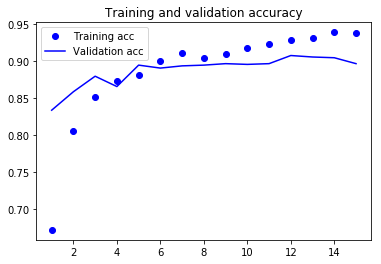

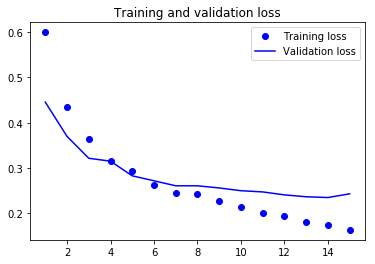

In [15]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This is Overfitting!
---
We can see that the training and validation accuracy curve diverge from each other rather quickly. This alone is might not be a sure shot sign of overfitting. We also observe that the training loss drops smoothly while validation loss actually increases. These two graphs in conjunction with each other indicate overfittig. 

**Why did this overfit despite dropout?**

We did *NOT* do data augmentation

Extending the ConvBase Model!
---
Pros: 
- Better performance (accuracy)
- Better Generalization (less overfitting) 
    - Because we can use data augmentation
    
Cons:
- Expensive compute

**Warning: Do not attempt this without a GPU. Your Python process can/will crash after a few hours**

In [18]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freezing ConvBase model: VGG16

Freezing means we do not update the layer weights in those particular layers. This is important for our present application.

In [20]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [21]:
model.summary()
# compare the Trainable Params value from the previous model summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [22]:
from keras.preprocessing.image import ImageDataGenerator
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')



train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 21s - loss: 0.4502 - acc: 0.7765 - val_loss: 0.3897 - val_acc: 0.8300
Epoch 2/30
100/100 [==============================] - 19s - loss: 0.2768 - acc: 0.8850 - val_loss: 0.2452 - val_acc: 0.8800
Epoch 3/30
100/100 [==============================] - 19s - loss: 0.2206 - acc: 0.9125 - val_loss: 0.1886 - val_acc: 0.9290
Epoch 4/30
100/100 [==============================] - 19s - loss: 0.1859 - acc: 0.9220 - val_loss: 0.0935 - val_acc: 0.9620
Epoch 5/30
100/100 [==============================] - 19s - loss: 0.1645 - acc: 0.9345 - val_loss: 0.0932 - val_acc: 0.9690
Epoch 6/30
100/100 [==============================] - 19s - loss: 0.1491 - acc: 0.9360 - val_loss: 0.1048 - val_acc: 0.9640
Epoch 7/30
100/100 [==============================] - 19s - loss: 0.1274 - acc: 0.9510 - val_loss: 0.0913 - val_acc: 0.9600
Epoch 8/30
100/100 [============================

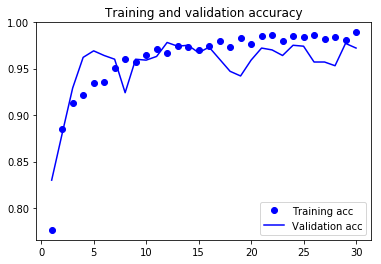

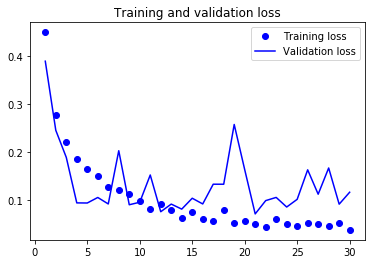

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# just for reference, let's calculate the test accuracy
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

%time test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
CPU times: user 2.2 s, sys: 48 ms, total: 2.24 s
Wall time: 2.63 s
test acc: 0.960999994278
